<a href="https://colab.research.google.com/github/Fhupsel/Projetos_Dados/blob/main/Projeto_M%C3%B3dulo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade google-cloud-documentai
!pip install googlemaps

In [ ]:
from google.oauth2 import service_account
from typing import List, Sequence
import pandas as pd
from google.api_core.client_options import ClientOptions
from google.cloud import documentai_v1 as documentai
import json
import googlemaps
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
key_path = #endereço JSON
%env GOOGLE_APPLICATION_CREDENTIALS=$key_path

env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/BI gcp - 4/bi-gcp-382113-f4a1a2a0c50d.json


In [ ]:
project_id = # id do projeto onde você ativou as APIs
location = 'us'
processor_id = # Processador form parser
file_path = '/content/drive/MyDrive/BI gcp - 4/enderecos.pdf'
mime_type = 'application/pdf'


def online_process(
    project_id: str,
    location: str,
    processor_id: str,
    file_path: str,
    mime_type: str,
) -> documentai.Document:
    """
    Processes a document using the Document AI Online Processing API.
    """

    # Instantiates a client
    docai_client = documentai.DocumentProcessorServiceClient(
        client_options=ClientOptions(
            api_endpoint=f"{location}-documentai.googleapis.com"
        )
    )

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    resource_name = docai_client.processor_path(project_id, location, processor_id)

    # Read the file into memory
    with open(file_path, "rb") as file:
        file_content = file.read()

    # Load Binary Data into Document AI RawDocument Object
    raw_document = documentai.RawDocument(content=file_content, mime_type=mime_type)

    # Configure the process request
    request = documentai.ProcessRequest(name=resource_name, raw_document=raw_document)

    # Use the Document AI client to process the sample form
    result = docai_client.process_document(request=request)

    return result.document


def get_table_data(
    rows: Sequence[documentai.Document.Page.Table.TableRow], text: str
) -> List[List[str]]:
    """
    Get Text data from table rows
    """
    all_values: List[List[str]] = []
    for row in rows:
        current_row_values: List[str] = []
        for cell in row.cells:
            current_row_values.append(
                text_anchor_to_text(cell.layout.text_anchor, text)
            )
        all_values.append(current_row_values)
    return all_values


def text_anchor_to_text(text_anchor: documentai.Document.TextAnchor, text: str) -> str:
    """
    Document AI identifies table data by their offsets in the entirity of the
    document's text. This function converts offsets to a string.
    """
    response = ""
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    for segment in text_anchor.text_segments:
        start_index = int(segment.start_index)
        end_index = int(segment.end_index)
        response += text[start_index:end_index]
    return response.strip().replace("\n", " ")


# Fazer a requisição e enviar o pdf ao processador Form Parser
document = online_process(
    project_id,
    location,
    processor_id,
    file_path,
    mime_type
)

# Extrair cabeçalho e linhas da tabela
header_row_values: List[List[str]] = []
body_row_values: List[List[str]] = []

# caso houvesse mais páginas no documento pdf
for page in document.pages:
    for table in page.tables:
        header_row_values = get_table_data(table.header_rows, document.text)
        body_row_values = get_table_data(table.body_rows, document.text)

# criar um Pandas Dataframe para armazenar os valores em formato tabular
df_enderecos = pd.DataFrame(
    data=body_row_values,
    columns=header_row_values[0],
)

In [ ]:
df_enderecos.head()

,id_cliente,logradouro,numero,bairro,cep,cidade,uf
0,1,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP
1,2,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP
2,3,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP
3,4,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP
4,5,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP


In [ ]:
df_enderecos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  30 non-null     object
 1   logradouro  30 non-null     object
 2   numero      30 non-null     object
 3   bairro      30 non-null     object
 4   cep         30 non-null     object
 5   cidade      30 non-null     object
 6   uf          30 non-null     object
dtypes: object(7)
memory usage: 1.8+ KB


In [ ]:
df_clientes = pd.read_csv("/content/drive/MyDrive/BI gcp - 4/clientes_dados.csv", sep=";")
df_clientes.head()

,id_cliente,nome,email,sexo,cpf,data_nasc
0,1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,06/01/1984
1,2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,06/01/1943
2,3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,04/02/1970
3,4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,22/06/1969
4,5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,07/09/1948


In [ ]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  30 non-null     int64 
 1   nome        30 non-null     object
 2   email       30 non-null     object
 3   sexo        30 non-null     object
 4   cpf         30 non-null     object
 5   data_nasc   30 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.5+ KB


In [ ]:
df_enderecos["id_cliente"] = df_enderecos["id_cliente"].astype("int64")
df_clientes["data_nasc"] = pd.to_datetime(df_clientes["data_nasc"], format='%d/%m/%Y')

In [ ]:
df_enderecos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  30 non-null     int64 
 1   logradouro  30 non-null     object
 2   numero      30 non-null     object
 3   bairro      30 non-null     object
 4   cep         30 non-null     object
 5   cidade      30 non-null     object
 6   uf          30 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.8+ KB


In [ ]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_cliente  30 non-null     int64         
 1   nome        30 non-null     object        
 2   email       30 non-null     object        
 3   sexo        30 non-null     object        
 4   cpf         30 non-null     object        
 5   data_nasc   30 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ KB


In [ ]:
df_completo = pd.merge(df_clientes, df_enderecos, on="id_cliente")
df_completo.head()

,id_cliente,nome,email,sexo,cpf,data_nasc,logradouro,numero,bairro,cep,cidade,uf
0,1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,1984-01-06,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP
1,2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,1943-01-06,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP
2,3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,1970-02-04,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP
3,4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,1969-06-22,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP
4,5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,1948-09-07,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP


In [ ]:
df_completo.set_index("id_cliente", inplace = True)
df_completo.head()

,nome,email,sexo,cpf,data_nasc,logradouro,numero,bairro,cep,cidade,uf
id_cliente,,,,,,,,,,,
1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,1984-01-06,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP
2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,1943-01-06,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP
3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,1970-02-04,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP
4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,1969-06-22,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP
5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,1948-09-07,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP


In [ ]:
# Usando geocode

gmaps = googlemaps.Client(key= chave )

enderecos = df_completo["logradouro"] + " " + df_completo['numero'] + ", " + df_completo["cidade"] + ", " + df_completo["uf"] + ", " + df_completo["cep"]

In [ ]:
coordenadas = []
for i, endereco in enumerate(enderecos):
    geocode_obj = gmaps.geocode(endereco)
    lat = geocode_obj[0]['geometry']['location']['lat']
    lon = geocode_obj[0]['geometry']['location']['lng']
    coordenadas.append([lat, lon])

{'lat': -23.6826179, 'lng': -46.3587757}

In [ ]:
df_coordenadas = pd.DataFrame(coordenadas, columns=["lat", "lon"])
df_coordenadas.set_index(df_coordenadas.index +1, inplace = True)
df_coordenadas.head()

,lat,lon
1,-21.619150,-48.368234
2,-22.748635,-47.630113
3,-23.111416,-46.536782
4,-23.495099,-46.602611
5,-23.122264,-48.920483


In [ ]:
df_completo = pd.concat([df_completo, df_coordenadas], axis = 1)
df_completo.head()

,nome,email,sexo,cpf,data_nasc,logradouro,numero,bairro,cep,cidade,uf,lat,lon
1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,1984-01-06,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP,-21.619150,-48.368234
2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,1943-01-06,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP,-22.748635,-47.630113
3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,1970-02-04,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP,-23.111416,-46.536782
4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,1969-06-22,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP,-23.495099,-46.602611
5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,1948-09-07,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP,-23.122264,-48.920483


In [ ]:
local_do_evento = "Estádio da Fonte Luminosa, Araraquara - SP"
distancias = []
dia_evento = datetime(2023,12,2)
for i, j in enumerate(enderecos):
    directions_result = gmaps.directions(j,
                                     local_do_evento,
                                     mode="driving",
                                     departure_time=dia_evento)
    distancia = directions_result[0]['legs'][0]['distance']['value']
    tempo = directions_result[0]['legs'][0]['duration']['value'] / 60
    distancias.append([distancia, tempo])

df_distancias = pd.DataFrame(distancias, columns=['distancia km', 'tempo em min'])
df_distancias.set_index(df_distancias.index + 1, inplace=True)

df_evento = pd.concat([df_completo['nome'], df_distancias], axis=1)
df_evento['distancia'] = (df_evento['distancia km'] / 1000).astype('int64')
df_evento.head()

,nome,distancia km,tempo em min,distancia
1,Sebastiana Tânia Mendes,33146,36.066667,33
2,Andrea Débora Campos,144817,115.616667,144
3,Rosa Jéssica Isis Barros,253539,185.833333,253
4,Vinicius Carlos Eduardo da Rocha,278701,208.800000,278
5,Cecília Milena Elisa Vieira,185087,156.066667,185


In [ ]:
df_completo.head()

,nome,email,sexo,cpf,data_nasc,logradouro,numero,bairro,cep,cidade,uf,lat,lon
1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,1984-01-06,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP,-21.619150,-48.368234
2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,1943-01-06,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP,-22.748635,-47.630113
3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,1970-02-04,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP,-23.111416,-46.536782
4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,1969-06-22,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP,-23.495099,-46.602611
5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,1948-09-07,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP,-23.122264,-48.920483


In [ ]:
df_evento.head()

,nome,distancia km,tempo em min,distancia
1,Sebastiana Tânia Mendes,33146,36.066667,33
2,Andrea Débora Campos,144817,115.616667,144
3,Rosa Jéssica Isis Barros,253539,185.833333,253
4,Vinicius Carlos Eduardo da Rocha,278701,208.800000,278
5,Cecília Milena Elisa Vieira,185087,156.066667,185


In [ ]:
from datetime import date
current_date = 2023
df_completo["data_nasc"] = df_completo["data_nasc"].astype(str)

In [ ]:
df_completo.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64')

In [ ]:
anos_nasc = []
for i in range(1,31):
  ano_nasc = df_completo["data_nasc"][i][0:4]
  anos_nasc.append(ano_nasc)
print(anos_nasc)

['1984', '1943', '1970', '1969', '1948', '1947', '1998', '1957', '1959', '1959', '1982', '1953', '1942', '1984', '1944', '1956', '1946', '1957', '1954', '1947', '1982', '1995', '1996', '1955', '1976', '1996', '1980', '1973', '1964', '1966']


In [ ]:
len(anos_nasc)

30

In [ ]:
anos_nasc[1]

'1943'

In [ ]:
idades = []
for i in anos_nasc:
  idade = current_date - int(i)
  idades.append(idade)
print(idades)

[39, 80, 53, 54, 75, 76, 25, 66, 64, 64, 41, 70, 81, 39, 79, 67, 77, 66, 69, 76, 41, 28, 27, 68, 47, 27, 43, 50, 59, 57]


In [ ]:
len(idades)

30

In [ ]:
df_idades = pd.DataFrame(idades, columns = ["idade"])
df_idades.set_index(df_idades.index +1, inplace = True)
df_idades.head()

,idade
1,39
2,80
3,53
4,54
5,75


In [ ]:
df_completo = pd.concat([df_completo, df_idades], axis = 1)
df_completo.head()

,nome,email,sexo,cpf,data_nasc,logradouro,numero,bairro,cep,cidade,uf,lat,lon,0,idade
1,Sebastiana Tânia Mendes,sebastiana_tania_mendes@trbvm.com,Feminino,938.319.088-42,1984-01-06,Rua Bento de Miranda Mello,356,Residencial Olivio Benassi,15993-037,Matão,SP,-21.619150,-48.368234,39,39
2,Andrea Débora Campos,andrea-campos75@caporal.biz,Feminino,782.328.538-08,1943-01-06,Rua Ricardo Arruda Ribeiro,745,Água Branca,13425-100,Piracicaba,SP,-22.748635,-47.630113,80,80
3,Rosa Jéssica Isis Barros,rosa.jessica.barros@optovac.com.br,Feminino,129.102.618-59,1970-02-04,Rua Dona Sylvia Finco Costa,870,Jardim Tapajós,12945-080,Atibaia,SP,-23.111416,-46.536782,53,53
4,Vinicius Carlos Eduardo da Rocha,viniciuscarlosdarocha@carreira.com.br,Masculino,437.270.578-66,1969-06-22,Rua Axicará,433,Vila Isolina Mazzei,02081-080,São Paulo,SP,-23.495099,-46.602611,54,54
5,Cecília Milena Elisa Vieira,cecilia-vieira98@amure.com.br,Feminino,726.017.228-27,1948-09-07,Rua Diamantino Armando,245,Vila Esperança,18703-800,Avaré,SP,-23.122264,-48.920483,75,75


In [ ]:
print(df_completo["idade"].mean())

56.93333333333333


In [ ]:
df_evento.head()

,nome,tempo em min,distancia
1,Sebastiana Tânia Mendes,36.066667,33
2,Andrea Débora Campos,115.616667,144
3,Rosa Jéssica Isis Barros,185.833333,253
4,Vinicius Carlos Eduardo da Rocha,208.800000,278
5,Cecília Milena Elisa Vieira,156.066667,185


In [ ]:
print(df_evento["distancia"].max())

370


In [ ]:
df_coordenadas.head()

,lat,lon
1,-21.619150,-48.368234
2,-22.748635,-47.630113
3,-23.111416,-46.536782
4,-23.495099,-46.602611
5,-23.122264,-48.920483


In [ ]:
!pip install geopandas==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.6 MB/s eta 0:00:00


In [ ]:
import geopandas

In [ ]:
gdf = geopandas.GeoDataFrame(df_coordenadas, geometry=geopandas.points_from_xy(df_coordenadas["lon"], df_coordenadas["lat"]))
print(gdf.head())


         lat        lon                     geometry
1 -21.619150 -48.368234  POINT (-48.36823 -21.61915)
2 -22.748635 -47.630113  POINT (-47.63011 -22.74864)
3 -23.111416 -46.536782  POINT (-46.53678 -23.11142)
4 -23.495099 -46.602611  POINT (-46.60261 -23.49510)
5 -23.122264 -48.920483  POINT (-48.92048 -23.12226)


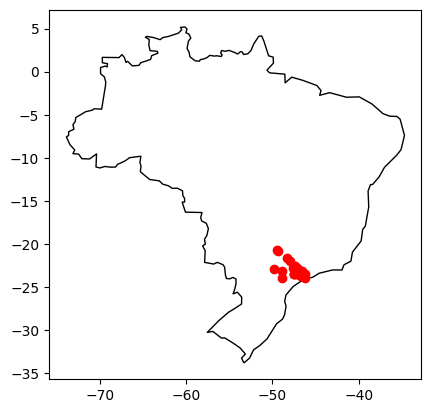

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.name == 'Brazil'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()